In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torchvision
import torch
import os
from PIL import Image
os.environ['KMP_DUPLICATE_LIB_OK']='True' # add this, otherwise the model will easily died because of plt
%matplotlib inline

In [2]:
# imageNet's mean and std
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def preprocess(img):
    transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=mean,std=std),
    ])
    return transform(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 959.5, 504.5, -0.5)

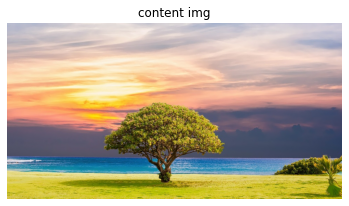

In [3]:
img = Image.open("./dd_tree.jpg")
img = preprocess(img).unsqueeze(0)
plt.imshow(img.squeeze(0).permute(1, 2, 0).numpy() * std + mean)
plt.title("content img")
plt.axis("off")


In [7]:
def lx_norm(input_data, alpha):
    return torch.sum(input_data ** alpha)

def TV_norm(input_data, beta):
    # x don not count the rightest and bottom pixel 
    x = input_data[..., :-1, :-1]
    
    y = input_data[..., 1:, :-1]
    z = input_data[..., :-1, 1:]
    return torch.sum(((y - x) ** 2 + (z - x) **2)**beta/2)

In [9]:
model = torchvision.models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
layer = model.features[:21].to(DEVICE)
print(layer)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


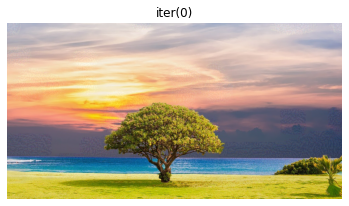

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


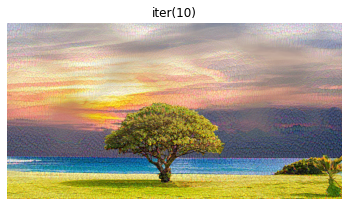

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


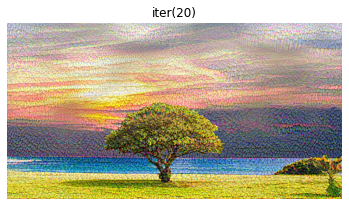

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


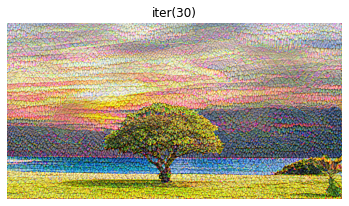

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


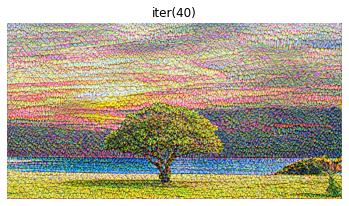

In [22]:
iter_num = 50
l_r = 1e-1
show_every = 10
filter_choosed = 0
lx_norm_weight = 1e-7
TV_norm_weight = 1e-7
alpha = 6
beta = 2


# choose zores make it easier to see the pattern
# otherwise the init random noise may cover the pattern

noise = img.clone().requires_grad_(True)


# noise = torch.randn(1, 3, 224, 224).requires_grad_(True)
optimizer = torch.optim.Adam([noise], lr=l_r)
for i in range(iter_num):
    layer_out = layer(noise.to(DEVICE))
  
    # we choose to maximize the mean of the selected filter
    loss = - torch.mean(layer_out[0, filter_choosed, ...] ** 2) + \
            lx_norm(noise, alpha) * lx_norm_weight + \
            TV_norm(noise, beta) * TV_norm_weight
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    
    # show res img

    if i % show_every == 0:
         out = noise.clone()
         plt.imshow(out.cpu().squeeze(0).permute(1,2,0).detach().numpy() * std + mean)
         plt.axis("off")
         plt.title(f"iter({i})")
         plt.show()